In [1]:
# %pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# %pip install jupyterlab
# %pip uninstall nvidia_cublas_cu11
# %pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
import torch, detectron2
# import tqdm as notebook_tqdm
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/userhome/cs2/u3572156/exit/envs/fyp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/bin/bash: nvcc: command not found
torch:  1.11 ; cuda:  cu113
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import load_lvis_json,get_lvis_instances_meta, register_lvis_instances


# Demo Run

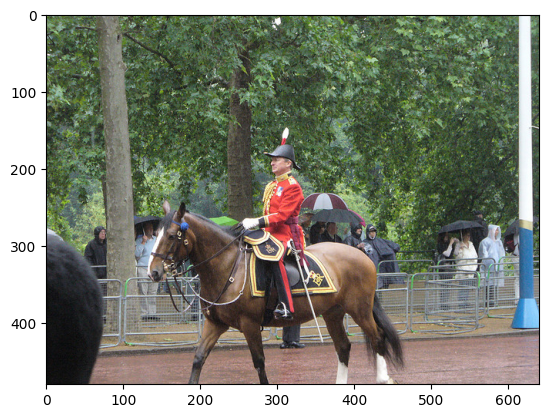

In [5]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("input.jpg")
im2 = im[:,:,::-1]
# OpenCV stores images in BGR order instead of RGB
plt.imshow(im2)
plt.show()
# cv2.imshow("image",im)

In [7]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[03/12 15:49:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/userhome/cs2/u3572156/exit/envs/fyp/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


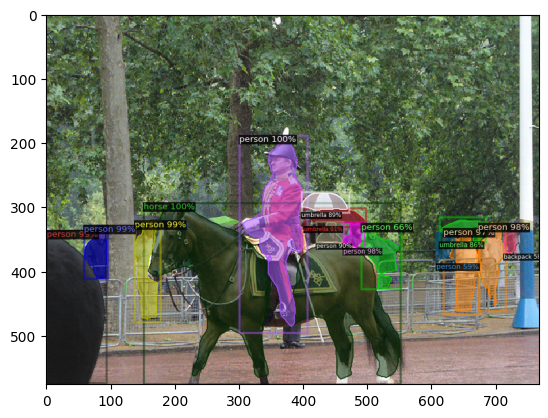

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
# print( MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
plt.show()

# LVIS Dataset Visualization

[03/12 15:49:51 d2.data.datasets.lvis]: Loaded 944 images in the LVIS format from lvis_v1_small.json


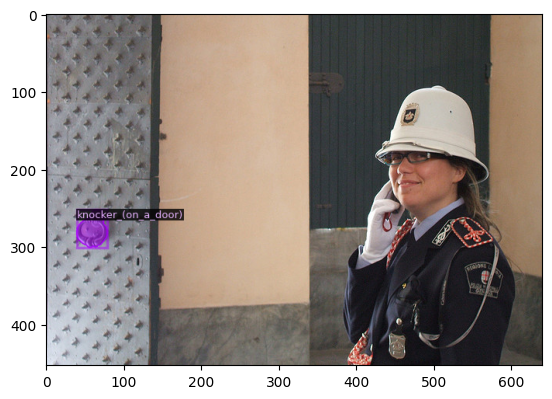

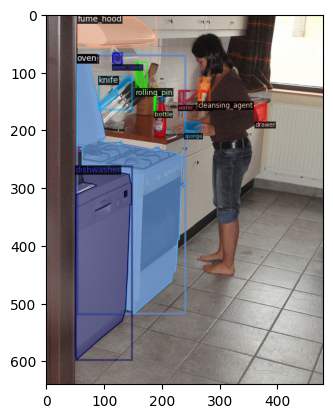

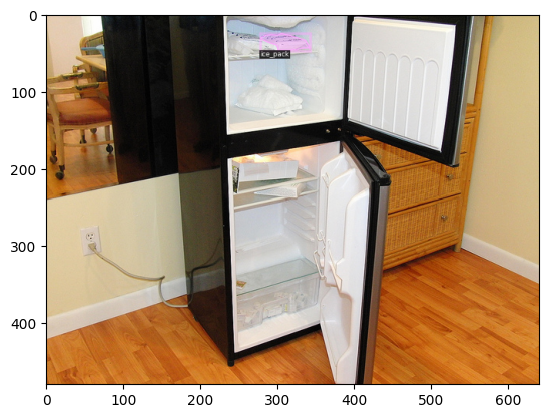

In [9]:
from detectron2.data.datasets import load_lvis_json,get_lvis_instances_meta

d = load_lvis_json("lvis_v1_small.json","")
# print(d[:10])
meta = get_lvis_instances_meta("v1")
# print(meta.keys())
for a in random.sample(d, 3):
    img = cv2.imread(a["file_name"])
    # OpenCV stores images in BGR order instead of RGB
    im2 = img[:,:,::-1]
    visualizer = Visualizer(im2, metadata=meta, scale=1)
    out = visualizer.draw_dataset_dict(a)
    plt.imshow(out.get_image())
    plt.show()

In [6]:
# Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

# Dataset Registration

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Copyright (c) Facebook, Inc. and its affiliates.

import copy
import json
import os
from collections import defaultdict

# This mapping is extracted from the official LVIS mapping:
# https://github.com/lvis-dataset/lvis-api/blob/master/data/coco_to_synset.json
COCO_SYNSET_CATEGORIES = [
    {"synset": "person.n.01", "coco_cat_id": 1},
    {"synset": "bicycle.n.01", "coco_cat_id": 2},
    {"synset": "car.n.01", "coco_cat_id": 3},
    {"synset": "motorcycle.n.01", "coco_cat_id": 4},
    {"synset": "airplane.n.01", "coco_cat_id": 5},
    {"synset": "bus.n.01", "coco_cat_id": 6},
    {"synset": "train.n.01", "coco_cat_id": 7},
    {"synset": "truck.n.01", "coco_cat_id": 8},
    {"synset": "boat.n.01", "coco_cat_id": 9},
    {"synset": "traffic_light.n.01", "coco_cat_id": 10},
    {"synset": "fireplug.n.01", "coco_cat_id": 11},
    {"synset": "stop_sign.n.01", "coco_cat_id": 13},
    {"synset": "parking_meter.n.01", "coco_cat_id": 14},
    {"synset": "bench.n.01", "coco_cat_id": 15},
    {"synset": "bird.n.01", "coco_cat_id": 16},
    {"synset": "cat.n.01", "coco_cat_id": 17},
    {"synset": "dog.n.01", "coco_cat_id": 18},
    {"synset": "horse.n.01", "coco_cat_id": 19},
    {"synset": "sheep.n.01", "coco_cat_id": 20},
    {"synset": "beef.n.01", "coco_cat_id": 21},
    {"synset": "elephant.n.01", "coco_cat_id": 22},
    {"synset": "bear.n.01", "coco_cat_id": 23},
    {"synset": "zebra.n.01", "coco_cat_id": 24},
    {"synset": "giraffe.n.01", "coco_cat_id": 25},
    {"synset": "backpack.n.01", "coco_cat_id": 27},
    {"synset": "umbrella.n.01", "coco_cat_id": 28},
    {"synset": "bag.n.04", "coco_cat_id": 31},
    {"synset": "necktie.n.01", "coco_cat_id": 32},
    {"synset": "bag.n.06", "coco_cat_id": 33},
    {"synset": "frisbee.n.01", "coco_cat_id": 34},
    {"synset": "ski.n.01", "coco_cat_id": 35},
    {"synset": "snowboard.n.01", "coco_cat_id": 36},
    {"synset": "ball.n.06", "coco_cat_id": 37},
    {"synset": "kite.n.03", "coco_cat_id": 38},
    {"synset": "baseball_bat.n.01", "coco_cat_id": 39},
    {"synset": "baseball_glove.n.01", "coco_cat_id": 40},
    {"synset": "skateboard.n.01", "coco_cat_id": 41},
    {"synset": "surfboard.n.01", "coco_cat_id": 42},
    {"synset": "tennis_racket.n.01", "coco_cat_id": 43},
    {"synset": "bottle.n.01", "coco_cat_id": 44},
    {"synset": "wineglass.n.01", "coco_cat_id": 46},
    {"synset": "cup.n.01", "coco_cat_id": 47},
    {"synset": "fork.n.01", "coco_cat_id": 48},
    {"synset": "knife.n.01", "coco_cat_id": 49},
    {"synset": "spoon.n.01", "coco_cat_id": 50},
    {"synset": "bowl.n.03", "coco_cat_id": 51},
    {"synset": "banana.n.02", "coco_cat_id": 52},
    {"synset": "apple.n.01", "coco_cat_id": 53},
    {"synset": "sandwich.n.01", "coco_cat_id": 54},
    {"synset": "orange.n.01", "coco_cat_id": 55},
    {"synset": "broccoli.n.01", "coco_cat_id": 56},
    {"synset": "carrot.n.01", "coco_cat_id": 57},
    {"synset": "frank.n.02", "coco_cat_id": 58},
    {"synset": "pizza.n.01", "coco_cat_id": 59},
    {"synset": "doughnut.n.02", "coco_cat_id": 60},
    {"synset": "cake.n.03", "coco_cat_id": 61},
    {"synset": "chair.n.01", "coco_cat_id": 62},
    {"synset": "sofa.n.01", "coco_cat_id": 63},
    {"synset": "pot.n.04", "coco_cat_id": 64},
    {"synset": "bed.n.01", "coco_cat_id": 65},
    {"synset": "dining_table.n.01", "coco_cat_id": 67},
    {"synset": "toilet.n.02", "coco_cat_id": 70},
    {"synset": "television_receiver.n.01", "coco_cat_id": 72},
    {"synset": "laptop.n.01", "coco_cat_id": 73},
    {"synset": "mouse.n.04", "coco_cat_id": 74},
    {"synset": "remote_control.n.01", "coco_cat_id": 75},
    {"synset": "computer_keyboard.n.01", "coco_cat_id": 76},
    {"synset": "cellular_telephone.n.01", "coco_cat_id": 77},
    {"synset": "microwave.n.02", "coco_cat_id": 78},
    {"synset": "oven.n.01", "coco_cat_id": 79},
    {"synset": "toaster.n.02", "coco_cat_id": 80},
    {"synset": "sink.n.01", "coco_cat_id": 81},
    {"synset": "electric_refrigerator.n.01", "coco_cat_id": 82},
    {"synset": "book.n.01", "coco_cat_id": 84},
    {"synset": "clock.n.01", "coco_cat_id": 85},
    {"synset": "vase.n.01", "coco_cat_id": 86},
    {"synset": "scissors.n.01", "coco_cat_id": 87},
    {"synset": "teddy.n.01", "coco_cat_id": 88},
    {"synset": "hand_blower.n.01", "coco_cat_id": 89},
    {"synset": "toothbrush.n.01", "coco_cat_id": 90},
]


def cocofy_lvis(input_filename, output_filename):
    """
    Filter LVIS instance segmentation annotations to remove all categories that are not included in
    COCO. The new json files can be used to evaluate COCO AP using `lvis-api`. The category ids in
    the output json are the incontiguous COCO dataset ids.

    Args:
        input_filename (str): path to the LVIS json file.
        output_filename (str): path to the COCOfied json file.
    """

    with open(input_filename, "r") as f:
        lvis_json = json.load(f)

    lvis_annos = lvis_json.pop("annotations")
    cocofied_lvis = copy.deepcopy(lvis_json)
    lvis_json["annotations"] = lvis_annos

    # Mapping from lvis cat id to coco cat id via synset
    lvis_cat_id_to_synset = {cat["id"]: cat["synset"] for cat in lvis_json["categories"]}
    synset_to_coco_cat_id = {x["synset"]: x["coco_cat_id"] for x in COCO_SYNSET_CATEGORIES}
    # Synsets that we will keep in the dataset
    synsets_to_keep = set(synset_to_coco_cat_id.keys())
    coco_cat_id_with_instances = defaultdict(int)

    new_annos = []
    ann_id = 1
    for ann in lvis_annos:
        lvis_cat_id = ann["category_id"]
        synset = lvis_cat_id_to_synset[lvis_cat_id]
        if synset not in synsets_to_keep:
            continue
        coco_cat_id = synset_to_coco_cat_id[synset]
        new_ann = copy.deepcopy(ann)
        new_ann["category_id"] = coco_cat_id
        new_ann["id"] = ann_id
        ann_id += 1
        new_annos.append(new_ann)
        coco_cat_id_with_instances[coco_cat_id] += 1
    cocofied_lvis["annotations"] = new_annos

    for image in cocofied_lvis["images"]:
        for key in ["not_exhaustive_category_ids", "neg_category_ids"]:
            new_category_list = []
            for lvis_cat_id in image[key]:
                synset = lvis_cat_id_to_synset[lvis_cat_id]
                if synset not in synsets_to_keep:
                    continue
                coco_cat_id = synset_to_coco_cat_id[synset]
                new_category_list.append(coco_cat_id)
                coco_cat_id_with_instances[coco_cat_id] += 1
            image[key] = new_category_list

    coco_cat_id_with_instances = set(coco_cat_id_with_instances.keys())

    new_categories = []
    for cat in lvis_json["categories"]:
        synset = cat["synset"]
        if synset not in synsets_to_keep:
            continue
        coco_cat_id = synset_to_coco_cat_id[synset]
        if coco_cat_id not in coco_cat_id_with_instances:
            continue
        new_cat = copy.deepcopy(cat)
        new_cat["id"] = coco_cat_id
        new_categories.append(new_cat)
    cocofied_lvis["categories"] = new_categories

    with open(output_filename, "w") as f:
        json.dump(cocofied_lvis, f)
    print("{} is COCOfied and stored in {}.".format(input_filename, output_filename))

In [ ]:
# DatasetCatalog.remove("cocofied_lvis_small")

In [13]:
cocofy_lvis("lvis_v1_small.json", "lvis_v1_small_cocofied.json")
d = load_lvis_json("lvis_v1_small_cocofied.json","")
# print(d[:10])
meta = get_lvis_instances_meta("cocofied")
register_lvis_instances("cocofied_lvis_small2", meta, "lvis_v1_small_cocofied.json", "")

lvis_v1_small.json is COCOfied and stored in lvis_v1_small_cocofied.json.
[03/12 15:50:10 d2.data.datasets.lvis]: Loaded 944 images in the LVIS format from lvis_v1_small_cocofied.json


# Model Registration

In [3]:
from modeling import vild_rcnn, config
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
config.add_vild_config(cfg)
cfg.merge_from_file("modeling/mask_rcnn_R_50_FPN_VILD.yaml")
cfg.MODEL.META_ARCHITECTURE = "VILD_RCNN"
trainer = DefaultTrainer(cfg) 

NameError: name 'SummaryWriter' is not defined

In [14]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
# cfg.merge_from_file(model_zoo.get_config_file("LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.merge_from_file("mask_rcnn_R_50_FPN_VILD.yaml")

cfg.DATASETS.TRAIN = ("cocofied_lvis_small2",)
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
# predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

AssertionError: Config file 'mask_rcnn_R_50_FPN_VILD.yaml' does not exist!